In [1]:
from IPython.display import YouTubeVideo

# Lecture: higher-order finite difference schemes 

In this lecture we will:
1. develop some code to test 1st and 2nd order finite difference schemes
- quantify their convergence rates
- develop higher-order differencing schemes
- quantify and compare their convergence rate with 1st and 2nd order schemes
- use the higher-order FD schemes to solve the linear advection equation


In [4]:
# YouTubeVideo('1j_HxD4iLn8')

In [5]:
import numpy as np
import math as m
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams.update({'font.size': 18})
matplotlib.rcParams['figure.figsize'] = [14,8]
# matplotlib.rcParams['text.usetex'] = False

# 1. Develop code to test 1st and 2nd order schemes
We start by, defining a test function below. We need to make sure that the argument x is such that the function is periodic in x. For periodic functions we don't need to change the discretization at the boundaries at x=0 and x=L, which makes things easier. 

We also define the analytical derivative for the test function. 


In [6]:
def function_with_periodic_boundary(x):
    y = np.sin(x)
    return y

def dydx_analytical(x):
    dydx = np.cos(x)
    return dydx

### Define x-coordinate
The periodic boundaries are at i-0.5 and N-0.5. The indicies in python are from 0 to N-1.


    periodic                                                          periodic
       BC                                                                BC
       |  points   points                                                |
      x=0   |        |                                                  x=L
       |    |        |                                                   |
       o -- X ------ X ------ X ------ X ---    ...    --- X ------ X -- o .. x
            |        |        |        |                   |        |     
           i=0       1        2        3                  N-2      N-1    


In [7]:
def coord(L,N):
    x = np.linspace(0.5, (N-0.5), N)/N*L
    return x

# check/print the points for L=2 and N=8
print(coord(2, 8))

[0.125 0.375 0.625 0.875 1.125 1.375 1.625 1.875]


### Plot the function (in this case y=sin(x))

Text(0, 0.5, '$y$')

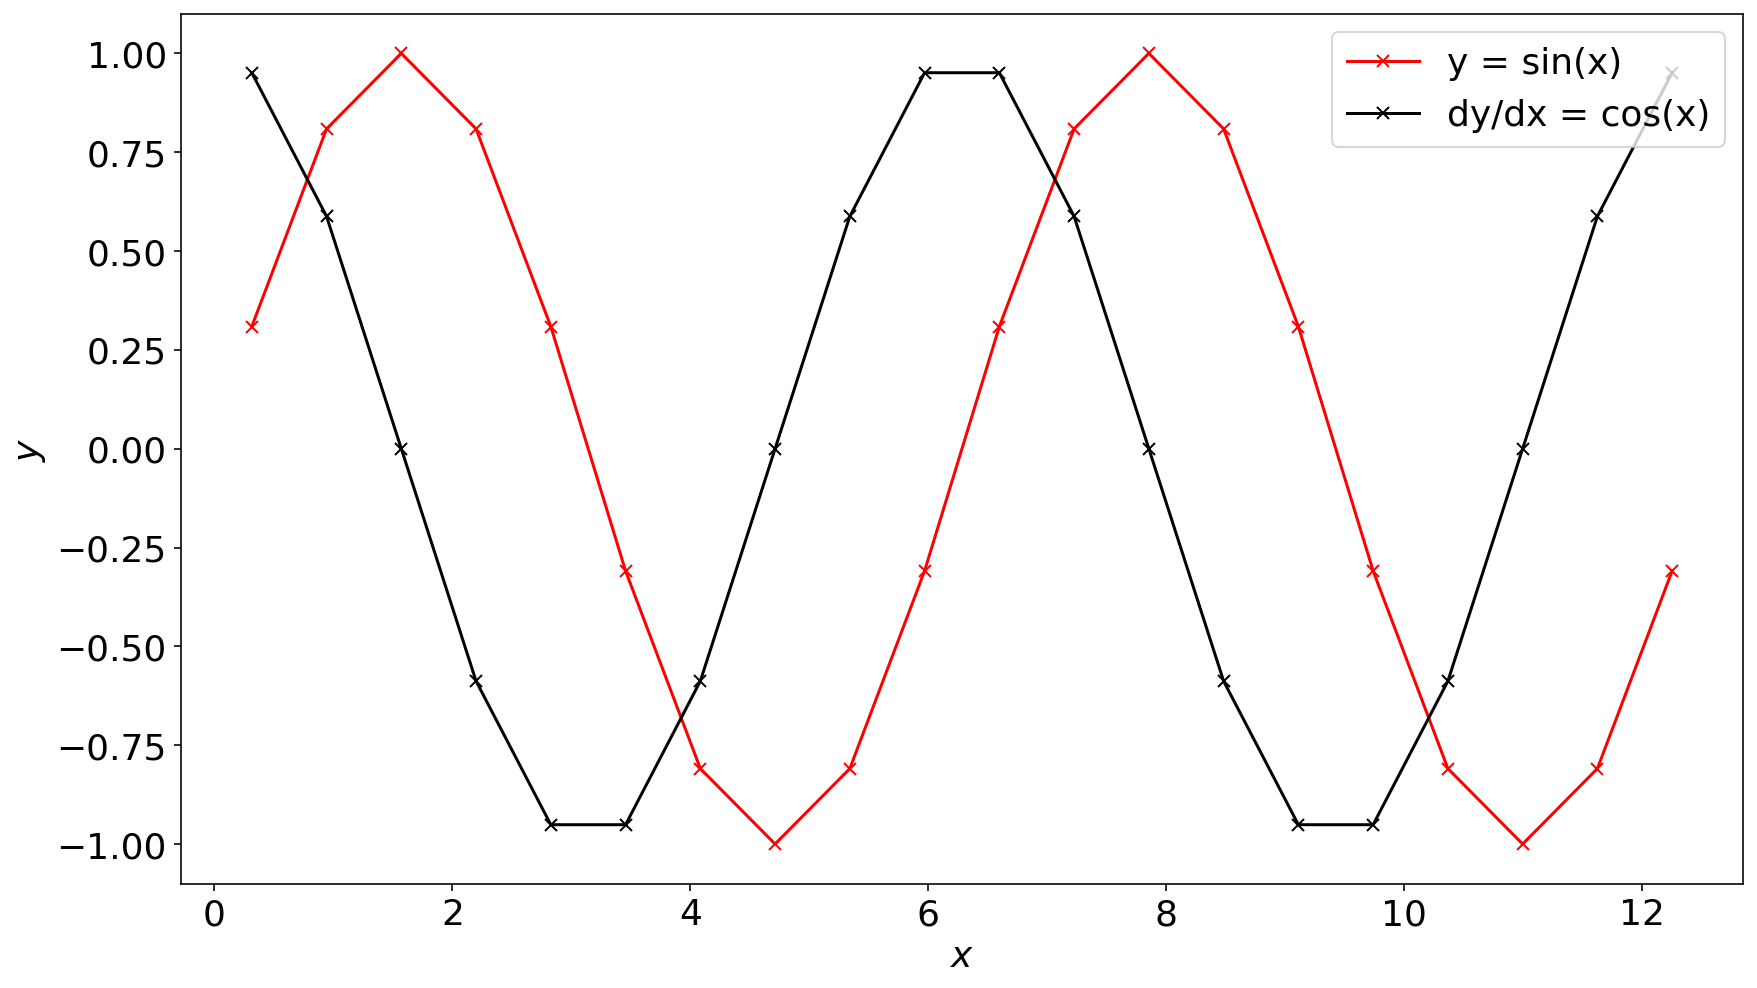

In [8]:
x = coord(4*np.pi, 20)
y = function_with_periodic_boundary(x)

plt.plot(x, y, 'rx-')
plt.plot(x, dydx_analytical(x), 'kx-')
plt.legend(['y = sin(x)','dy/dx = cos(x)'])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

### Implement numerical derivatives

- backward difference: $\frac{\partial y}{\partial x} \approx \frac{y_i-y_{i-1}}{\Delta x}$
- central difference: $\frac{\partial y}{\partial x} \approx \frac{y_{i+1}-y_{i-1}}{2\Delta x}$


In [ ]:
def backwardFD_1stOrd(y,x):
    
    # get dx by simply subtrating x1-x0
    dx = x[1]-x[0]
    dydx = np.zeros_like(x)
    
    # calculate the derivative for all i's
    # note, the '%' in line 11 is a modulo operator, which makes sure that i-1 and i+1 
    # always stay within the array boundaries == periodic boundary conditions. 
    for i in range(len(x)):
        dydx[i] = (y[i] - y[(i-1)%len(x)])/(dx)
    return dydx

def centralFD_2ndOrd(y,x):
    dx = x[1]-x[0]
    dydx = np.zeros_like(x)
    for i in range(len(x)):
        dydx[i] = (y[(i+1)%len(x)] - y[(i-1)%len(x)])/(2*dx)
    return dydx

In [ ]:
plt.plot(x, dydx_analytical(x), 'k--')
plt.plot(x, backwardFD_1stOrd(y,x), 'rx-')
plt.plot(x, centralFD_2ndOrd(y,x), 'bx-')
plt.legend(['dy/dx = cos(x)','1st order','2nd order'])
plt.xlabel('$x$')
plt.ylabel('$dy/dx$')

### <font color=blue>Observations: </font>
- the 1st-order backward differencing scheme shifts the derivative. 
- the 2nd order central differencing scheme is more accurate, but underpredicts the derivative at the extrema
    

# 2. Quantify convergence rates
Check convergence rates of backward and central differencing schemes

In [ ]:
dx = []
error_1stOrd = []
error_2ndOrd = []

# define a length of 4 pi
L = 4.0*np.pi 

# lets increase the number of points N as a function of 2 to the power of 'i', 
# where 'i' is from 2 to 11 (note "range" stops at N-1!)
for i in range(2,12):
    
    x = coord(L, 2**(i+1))
    y = function_with_periodic_boundary(x)

    dydx_1stOrd = backwardFD_1stOrd(y,x)
    dydx_2ndOrd =  centralFD_2ndOrd(y,x)
                
    dx.append(x[1]-x[0])
    error_1stOrd.append(sum(np.abs(dydx_1stOrd-dydx_analytical(x)))/(len(x)))
    error_2ndOrd.append(sum(np.abs(dydx_2ndOrd-dydx_analytical(x)))/(len(x)))

plt.loglog(dx, error_1stOrd,'rx')
plt.loglog(dx, error_2ndOrd,'bx')

plt.loglog(dx, np.array(dx),'r--')
plt.loglog(dx, np.array(dx)**2,'b--')
plt.xlabel('$\Delta x$')
plt.ylabel('Error, infinity norm')

### <font color=blue>Observations:</font>

- You can see that the slopes are 1 and 2 for the first and second order derivatives, respectively. 
- For example, for the second order FD scheme, the error reduced by two orders of magnitude by decreasing $\Delta x$ by one order of magnitude! Also important to mention that the error (x-symbols) for the second-order scheme is always lower thatn for the fdirst-order scheme.

# 3. Higher-order finite difference scheme

We can obtain a higher order scheme by extending the finite difference stencil. For example we can define a five-point stencil: 
$$ \frac{\partial^{(1)}y}{\partial x^{(1)}} = \frac{1}{\Delta x}\left(a y_{i-2} +b y_{i-1} + c y_{i} + d y_{i+1} + e y_{i+2}\right)$$

Now we can use a Taylor expansion for $y$ at all $x_i$ positions. As we will see later, we can truncate the Taylor expansion after five terms. 

At $(i-2)$ we have the coefficient $a$:    $\quad y_{i-2} = y_i-\frac{2\Delta x}{1!}\frac{\partial y}{\partial x} + \frac{(2\Delta x)^2}{2!}\frac{\partial^2y}{\partial x^2} - \frac{(2\Delta x)^3}{3!}\frac{\partial^3y}{\partial x^3} + \frac{(2\Delta x)^4}{4!}\frac{\partial^4y}{\partial x^4} + \mathcal{O}(\Delta x^5)$

At $(i-1)$ we have the coefficient $b$:    $\quad y_{i-1} = y_i-\frac{\Delta x}{1!}\frac{\partial y}{\partial x} + \frac{(\Delta x)^2}{2!}\frac{\partial^2y}{\partial x^2} - \frac{(\Delta x)^3}{3!}\frac{\partial^3y}{\partial x^3} + \frac{(\Delta x)^4}{4!}\frac{\partial^4y}{\partial x^4} + \mathcal{O}(\Delta x^5)$

At $(i~~~~~~~)$ we have the coefficient $c$:    $\quad y_{i} = y_i$ 

At $(i+1)$ we have the coefficient $d$:    $\quad y_{i+1} = y_i+\frac{\Delta x}{1!}\frac{\partial y}{\partial x} + \frac{(\Delta x)^2}{2!}\frac{\partial^2y}{\partial x^2} + \frac{(\Delta x)^3}{3!}\frac{\partial^3y}{\partial x^3} + \frac{(\Delta x)^4}{4!}\frac{\partial^4y}{\partial x^4} + \mathcal{O}(\Delta x^5)$

At $(i+2)$ we have the coefficient $e$:    $\quad y_{i+2} = y_i+\frac{2\Delta x}{1!}\frac{\partial y}{\partial x} + \frac{(2\Delta x)^2}{2!}\frac{\partial^2y}{\partial x^2} + \frac{(2\Delta x)^3}{3!}\frac{\partial^3y}{\partial x^3} + \frac{(2\Delta x)^4}{4!}\frac{\partial^4y}{\partial x^4} + \mathcal{O}(\Delta x^5)$

Now we can substitute the expansions into the five-point finite difference stencil and  collect the terms for the coefficients to build a matrix. Note, since we have five coefficients we need five equations. Hence we need five terms of the Taylor expansion at each location $x_i$.

$$
\begin{matrix} 
~ & a & b & c & d & e\\ \hline
1: &1 & 1 & 1 & 1 & 1\\
(\Delta x) \frac{\partial y}{\partial x} :              & -2 & -1 & 0 & 1 & 2\\
(\Delta x)^2 \frac{\partial^{(2)}y}{\partial x^{(2)}}  : &  2 & \frac{1}{2} & 0 & \frac{1}{2} & 2\\
(\Delta x)^3 \frac{\partial^{(3)}y}{\partial x^{(3)}} : & -\frac{4}{3} & -\frac{1}{6} & 0 & \frac{1}{6} & \frac{4}{3}\\
(\Delta x)^4 (\frac{\partial^{(4)}y}{\partial x^{(4)}} : & \frac{2}{3} & \frac{1}{24} & 0 )&  \frac{1}{24} & \frac{2}{3}
\end{matrix} = 
\begin{bmatrix}
0\\ \frac{\partial^{(1)}y}{\partial x^{(1)}} \\0\\0\\0
\end{bmatrix}$$

Now we can solve the linear system to get the coefficients:
$$ \begin{bmatrix}
    1 & 1 & 1 & 1 & 1\\
    -2 & -1 & 0 & 1 & 2\\
    2 &\frac{1}{2} & 0 & \frac{1}{2} & 2\\
    -\frac{4}{3} & -\frac{1}{6} & 0 & \frac{1}{6} & \frac{4}{3}\\
    \frac{2}{3} & \frac{1}{24} & 0 & \frac{1}{24} & \frac{2}{3}
   \end{bmatrix}
    \times 
   \begin{bmatrix}a\\b\\c\\d\\e\end{bmatrix}
   =
    \begin{bmatrix}
        0\\ \frac{\partial^{(1)}y}{\partial x^{(1)}} \\0\\0\\0
    \end{bmatrix}.
$$


This is the matrix:

In [ ]:
A = np.matrix([[1,1,1,1,1], 
               [-2, -1, 0, 1, 2], 
               [ 2, 1/2, 0, 1/2, 2], 
               [-4/3, -1/6, 0, 1/6, 4/3], 
               [2/3, 1/24, 0, 1/24, 2/3]] ) 

Now solve the linear system to obtain the coefficients

In [ ]:
from scipy import linalg 

coeff = linalg.solve(A, [0,1,0,0,0]) 

print('These are the coefficients [a,b,c,d,e]: \n',coeff)

### For arbitrary stencils: 
We can also define a function which takes as inputs a stencil and the value of the derivative. The value of the derivative is: 1... first derivative, 2... 2nd derivative, and so on. Note, the stencil has to be larger for higher derivatives. 

Example: A stencil of [-2,-1,0,1,2] and the value '1', gives a 4th-order, first derivative. 

By inspecting the matrix above, it is easy to see the pattern the coeffients can be  calculated. The coefficients are:
$$ A(i,j) = \frac{j^i}{i!},$$
where $j$ is the stencil (for example [-2,-1,0,1,2]) and $i$ is the length of the stencil (in this case i=[0,1,2,3,4]).

In [ ]:
def get_FD_coeff(stencil, derivative):
    A = np.ones((len(stencil), len(stencil)))

    for i in range(1,len(stencil)):
        A[i,:] = np.power(stencil,i)/m.factorial(i)

    b = np.zeros(len(stencil))
    b[derivative] = 1
    return linalg.solve(A,b)

Let's test the function for the second-order 1st derivative. The result should be [-1/2, 0, 1/2]

In [ ]:
coeff = get_FD_coeff([-1,0,1], 1)
print(coeff)

And for forth-order 1st derivative: 

In [ ]:
coeff = get_FD_coeff([-2,-1,0,1,2], 1)
print(coeff)

And for second-order, 2nd derivative. 

You can test other derivatives and compare the results with https://en.wikipedia.org/wiki/Finite_difference_coefficient

In [ ]:
coeff = get_FD_coeff([-1,0,1], 2)
print(coeff)

# 4. Quantify convergence rate for a higher-order finite difference scheme
To calculate the derivative for an arbitrary FD scheme, we can also say: 
$$ \frac{\partial y}{\partial x}\left.\right|_{\mathrm{numerical}} = \sum^\mathrm{len(Stencil)-1}_{i=0} \mathrm{coeff}_i \times y[\mathrm{Stencil}_i],$$
with the 'Stencil' the FD stencil and 'coeff' the coeffcients at each stencil point. For example, for a fourth order scheme, the stencil is [-2,-1,0,1,2].

In [ ]:
def higherOrder_FD(y,x,stencil):
    
    coeff = get_FD_coeff(stencil, 1)
    
    dx = x[1]-x[0]
    dydx = np.zeros_like(x)
    
    for i in range(len(x)):
        for idx,s in enumerate(stencil):
            dydx[i] = dydx[i] + coeff[idx]*y[(i+s)%len(x)]
            
    return dydx/dx

In [ ]:
deltax = []
error_1stOrd = []
error_2ndOrd = []
error_highO6 = []
error_highO12 = []

L = 4.0*np.pi

for i in range(2,12): 
    
    x = coord(L, 2**(i+1))
    y = function_with_periodic_boundary(x)

    dydx_1stOrd = backwardFD_1stOrd(y,x)
    dydx_2ndOrd =  centralFD_2ndOrd(y,x)
    
    # this is the higher-order FD implementation, change the stencil in [] below
    dydx_highOr6 = higherOrder_FD(y,x,[-3,-2,-1,0,1,2,3])
    
    # this is the higher-order FD implementation, change the stencil in [] below
    # np.arange(-6,7) = [-6,-5....5,6]
    dydx_highOr12 = higherOrder_FD(y,x,np.arange(-6,7))
    
                
    deltax.append(x[1]-x[0])
    error_1stOrd.append(sum(np.abs(dydx_1stOrd-dydx_analytical(x)))/(len(x)))
    error_2ndOrd.append(sum(np.abs(dydx_2ndOrd-dydx_analytical(x)))/(len(x)))
    error_highO6.append(sum(np.abs(dydx_highOr6-dydx_analytical(x)))/(len(x)))
    error_highO12.append(sum(np.abs(dydx_highOr12-dydx_analytical(x)))/(len(x)))

plt.loglog(deltax, error_1stOrd,'r*')
plt.loglog(deltax, error_2ndOrd,'b^')
plt.loglog(deltax, error_highO6,'kx')
plt.loglog(deltax, error_highO12,'ms')

plt.loglog(deltax, 4e-1*np.array(deltax),'r--')
plt.loglog(deltax, 2e-1*np.array(deltax)**2,'b--')
plt.loglog(deltax, 7e-3*np.array(deltax)**6,'k--')
plt.loglog(deltax, 3e-5*np.array(deltax)**12,'m--')
plt.legend(['1st order','2nd order','6th order','12th order'])
plt.xlabel('$\Delta x$')
plt.ylabel('Error: infinity norm')
plt.ylim(1e-15,10)

### <font color=blue>Try yourself</font>
- Try other schemes to see how they behave. You can also use one-sided (off centered) FD schemes.

### We can also plot the derivatives to visually inspect the differences

In [ ]:
x = coord(4*np.pi, 9)
y = function_with_periodic_boundary(x)

plt.plot(x, dydx_analytical(x), 'ks')
plt.plot(x, centralFD_2ndOrd(y,x), 'y-')
plt.plot(x, higherOrder_FD(y,x,[-2,-1,0,1,2]), 'b-')
plt.plot(x, higherOrder_FD(y,x,[-3,-2,-1,0,1,2,3]), 'r-')
plt.legend(['dy/dx = cos(x)','2nd order','4th order','6th order'])
plt.xlabel('$\Delta x')
plt.ylabel('dy/dx')

# 5. Now let's test the linear advection equation with different FD schemes 

The equation for the linear advection is: 
$$\frac{\partial \phi}{\partial t} + U\frac{\partial \phi}{\partial x} = 0$$

First, we define the domain, the initial condition and other parameters:

In [ ]:
L   = 1                # length of domain
N   = 100              # number of points
U   = 1.0              # advection velocity 
CFL = 1.0              # define CFL number

x   = coord(L,N)       # x - coordinates based on L and N=100
dx  = x[1]-x[0]        # get delta x
dt  = CFL*dx/abs(U)    # calculate delta t based on the CFL number
nTSPerPeriod = L/dt/U  # number of time steps per period  


# define initial profile
initialProfile = 2

if initialProfile == 1:    # hump  
    fact = 0.02
    phi = np.tanh((x - 0.3*L)/fact) + np.tanh((0.7*L - x)/fact)

elif initialProfile == 2:  # Gauss bell
    sigma = 0.1
    t = x-0.5
    phi = np.exp(-((x-0.5)/sigma)**2)
    
elif initialProfile == 3:  # Mexican hat
    sigma = 0.10
    t = x-0.5
    phi = (1-(t/sigma)**2)*np.exp(-1/(2*sigma**2)*t**2)

phiInitial = phi


# plot initial profile
plt.figure(figsize=(12, 4))
plt.plot(x,phi,'rx--')

## Classic fourth-order method Runge-Kutta scheme

We can define the right-hand-side as: 
$$RHS = -U\frac{\partial \phi}{\partial x}$$
such that
$$\frac{\partial \phi}{\partial t} = RHS$$

With the definition of the RHS we can simply code the Runge-Kutta scheme:
$$ rhs_1 = rhs(\phi) $$
$$ rhs_2 = rhs(\phi + 0.5*\Delta t~rhs_1) $$
$$ rhs_3 = rhs(\phi + 0.5*\Delta t~rhs_2) $$
$$ rhs_3 = rhs(\phi + \Delta t~rhs_3) $$
$$ \phi^{n+1} = \phi^n + \Delta t (rhs_1 + 2~rhs_2 + 2~rhs_3 + rhs_4)/6$$ 

In [ ]:
def RHS(phi, stencil):
    return - U * higherOrder_FD(phi, x, stencil)

def rk4(phi, stencil): 
    rhs1 = RHS(phi,             stencil)
    rhs2 = RHS(phi + dt/2*rhs1, stencil)
    rhs3 = RHS(phi + dt/2*rhs2, stencil)
    rhs4 = RHS(phi + dt*rhs3,   stencil) 
    return phi + dt*(rhs1 + 2*rhs2 + 2*rhs3 + rhs4)/6

### Let's run:

In [ ]:
# Before we start, we need to import some libraries to make animations
from matplotlib import animation,rc
rc('animation', html='jshtml')
from IPython.display import HTML
matplotlib.rcParams['animation.embed_limit'] = 1e8 ### this is almost 100MB so be careful

In [ ]:
# set phi to initial values 
phi1 = phiInitial
phi2 = phiInitial
phi3 = phiInitial

# initialize figure, set size, get axis and figure handles, and plot initial condition
fig = plt.figure(figsize=(12, 7))
ax  = plt.axes(xlim=(0, 1),ylim=(-.2, 1.1))
ax.plot(x, phiInitial, 'rx')
line1, = ax.plot([], [], lw=2)
line2, = ax.plot([], [], lw=2)
line3, = ax.plot([], [], lw=2)
plt.legend(['Initial','1st-order','2nd-order','higher-order'],loc='upper right')
plt.close(fig)

# define init for animation
def init():
    line1.set_data([], [])
    line2.set_data([], [])
    line3.set_data([], [])
    return line1,line2,line3

# define animation
def animate(i): 
    global phi1,phi2,phi3
    line1.set_data(x, phi1)
    line2.set_data(x, phi2)
    line3.set_data(x, phi3)
    phi1 = rk4(phi1, stencil = [    -1, 0      ])  # 1st-order backward diff
    phi2 = rk4(phi2, stencil = [    -1, 0, 1   ])  # 2nd-order central diff
    phi3 = rk4(phi3, stencil = [-2, -1, 0, 1, 2])  # 4th-order central diff
    return line1,line2,line3

# animate!
anim = animation.FuncAnimation(fig, animate, init_func=init, 
                               frames=int(4*nTSPerPeriod)+1, interval=15, blit=True)
anim

### <font color=blue>Change schemes and discuss results:</font>
- change the stencil in line 24 to backward difference scheme: 'stencil = [-1,0]'
- change the stencil in line 24 to backward difference scheme: 'stencil = [-1,0,1]'
- switch from rk4 to to Euler forward time-integration scheme using the previous stencil. Solution will blow up. Why?
- Try other higher-order schemes to see how they behave. Switch back to rk4. 
- also try to change the initial profile in the code above (for example, the value of fact)
- feel free to changed other things. 

# 6. Investigate results in more detail
So the observation we made are: 
- backward differencing scheme is very diffusive! This can be explained that we truncated the Taylor expansion at the second order term. So, the leading error is like a 

In [ ]:
def plotResult(x,phi):
    fig, axs = plt.subplots(3,figsize=(12, 10))

    axs[0].plot(x,phiInitial,'rx')
    axs[0].plot(x,phi,'b-')
    axs[0].set_xlabel('$x$')
    axs[0].set_ylabel('$\phi$')

    phiInit_fft = np.fft.fft(phiInitial)
    phi_fft     = np.fft.fft(phi)

    axs[1].semilogy(np.arange(1,len(x)//2),1/(len(x)/2)*np.abs(phiInit_fft)[1:len(x)//2],'rx-')
    axs[1].semilogy(np.arange(1,len(x)//2),1/(len(x)/2)*np.abs(phi_fft)[1:len(x)//2],'bo-')
    axs[1].set_ylabel('Amplitude: abs(fft($\phi$))')

    axs[2].plot(np.arange(1,len(x)//2),180/np.pi*np.angle(phiInit_fft)[1:len(x)//2],'rx-')
    axs[2].plot(np.arange(1,len(x)//2),180/np.pi*np.angle(phi_fft)[1:len(x)//2],'bo-')
    axs[2].set_xlabel('mode')
    axs[2].set_ylabel('phase angle(fft($\phi$))')

In [ ]:
def makeAnimationOfSingleWaves(stencil):

    # initialize figure, set size, get axis and figure handles, and plot initial condition
    fig = plt.figure(figsize=(12, 8))
    ax1 = plt.axes(xlim=(0, 1), ylim=(-0.3, 0.3))
    
    lines = []
    for i in range(len(phi)):
        line, = ax1.plot([], [], lw=2)
        lines.append(line)
    plt.close(fig)

    # define init for animation
    def init():
        for line in lines:
            line.set_data([], [])
        return lines

    # define animation
    def animate(i): 
        global phi

        fftphi = np.fft.fft(phi)
        for i,line in enumerate(lines):
            singleWave = np.zeros_like(fftphi)
            singleWave[i] = fftphi[i]
            p = np.fft.ifft(singleWave)
            line.set_data(x, p.real)

        for i in range(4):
            phi = rk4(phi, stencil)
        return lines

    # animate!
    anim = animation.FuncAnimation(fig, animate, init_func=init, 
                                   frames=int(2*nTSPerPeriod)+1, interval=30, blit=True)
    return anim

### 1st-order backward difference  

In [ ]:
phi = phiInitial

for i in range(int(4*nTSPerPeriod)):
    phi = rk4(phi, [-1,0])

plotResult(x,phi)

In [ ]:
phi = phiInitial
makeAnimationOfSingleWaves(stencil=[-1,0])

### 2nd-order central difference scheme 

In [ ]:
phi = phiInitial

for i in range(int(6*nTSPerPeriod)):
    phi = rk4(phi, stencil=[-1,0,1])

plotResult(x,phi)

In [ ]:
phi = phiInitial
makeAnimationOfSingleWaves(stencil=[-1,0,1])

### Higer-order difference scheme 

In [ ]:
phi = phiInitial

for i in range(int(1.0*nTSPerPeriod)):
    phi = rk4(phi, stencil=[-2,-1,0,1,2])

plotResult(x,phi)

In [ ]:
phi = phiInitial
makeAnimationOfSingleWaves(stencil=[-2,-1,0,1,2])